In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import random
from tqdm.auto import tqdm
import imageio
import einops
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.datasets import FashionMNIST
import os
device = torch.device("cuda:0")

In [2]:
import importlib
from GAN_modules import * 
from DDGAN import *

In [3]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
batch_size = 64

dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [4]:
def training_loop(ddgan, loader, n_epochs, optimizerG, optimizerD, device, r1,
                  schedulerG=None, schedulerD=None, store_path="ddgan_model.pt"):

    best_loss = float("inf")
    n_steps = ddgan.n_steps
    netG = ddgan.generator
    netD = ddgan.discriminator

    pos_coeff = Posterior_Coefficients(ddgan, device)

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        print(f'Epoch {epoch+1}/{n_epochs}')
        
        epoch_errG = 0.0
        epoch_errD = 0.0
           
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            for p in netD.parameters():
                p.requires_grad = True
                
            netD.zero_grad()
                
            x0 = batch[0].to(device)
            n = len(x0)
            
            t = torch.randint(0, n_steps, (n,)).to(device)
              
            x_t, x_tp1 = q_sample_pairs(ddgan, x0, t)
            x_t.requires_grad = True
            
            #train D with real            
            D_real = netD(x_t, t, x_tp1.detach()).view(-1)
            errD_real = (-0.5*torch.tanh(D_real)).mean()
            
            errD_real.backward(retain_graph=True)
                
            grad_real = torch.autograd.grad(
                    outputs=D_real.sum(), inputs=x_t, create_graph=True)[0]
            grad_penalty = (
                grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
                            ).mean()  
            grad_penalty = r1 / 2 * grad_penalty
            grad_penalty.backward()
                                           
            #train D with fake from G
            latent_z = torch.randn(n, netG.zsize).to(device)
            
            x_0_predict = netG(x_tp1, t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
            
            output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
    
            errD_fake = (0.5*torch.tanh(output)).mean()
            errD_fake.backward()
            
            errD = errD_real.detach() + errD_fake.detach()
            optimizerD.step()    
            
            #train G without D
            for p in netD.parameters():
                p.requires_grad = False
            netG.zero_grad()
            
            
            t = torch.randint(0, n_steps, (n,)).to(device)
            
            x_t, x_tp1 = q_sample_pairs(ddgan, x0, t)
            
            latent_z = torch.randn(n, netG.zsize).to(device)
            
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
            
            output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)     
            
            errG = (-0.5*torch.tanh(output)).mean()
            
            errG.backward()
            optimizerG.step()

            epoch_errG += errG.detach() * n / len(loader.dataset)
            epoch_errD += errD.detach() * n / len(loader.dataset)
        
        if schedulerD is not None:
            schedulerD.step()
        if schedulerG is not None:
            schedulerG.step()

        log_string = f"G loss: {epoch_errG:.4f}, D loss: {epoch_errD:.4f}"

        # Storing the model
        torch.save(ddgan.state_dict(), store_path)
        print(log_string)
        print('-' * 75)
    torch.cuda.empty_cache()

In [5]:
from CustomizableCosineDecayScheduler import CosineDecayWithWarmUpScheduler as CD_scheduler
n_steps, min_beta, max_beta = 10, 3e-1, 9e-1
r1 = 0.0001

In [55]:
try:
    del generator
except: pass
try:
    del discriminator
except: pass
try:
    del ddgan
except: pass
torch.cuda.empty_cache()


generator = Generator(time_emb_dim=50, n_steps=n_steps, device=device, zsize=100)
discriminator = Discriminator(time_emb_dim=50, n_steps=n_steps, device=device)


ddgan = DDGAN(generator, discriminator, n_steps=n_steps, 
              min_beta=min_beta, max_beta=max_beta, emb_dim=50,
              device=device).to(device)
#ddgan = best_model

optimizerG = optim.Adam(ddgan.generator.parameters(), betas=(0.7, 0.99),
                       lr=3e-5)
optimizerD = optim.Adam(ddgan.discriminator.parameters(), betas=(0.7, 0.99),
                       lr=3e-5)

schedulerG = CD_scheduler(optimizerG, 
                    max_lr=3e-5, min_lr=3e-8, num_step_down=20, 
                    num_step_up=0, gamma=0.5, alpha=0.3)
schedulerD = CD_scheduler(optimizerG, 
                    max_lr=3e-5, min_lr=3e-8, num_step_down=20, 
                    num_step_up=0, gamma=0.4, alpha=0.3)

ddgan.train()
training_loop(ddgan, loader, n_epochs=20, optimizerG=optimizerG, optimizerD=optimizerD, 
              r1=r1, schedulerG=schedulerG, schedulerD=schedulerD,
              device=device, store_path="ddgan_tv_model.pt")

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20


Epoch 1/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.2174, D loss: -0.0694
---------------------------------------------------------------------------
Epoch 2/20


Epoch 2/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.2687, D loss: -0.0610
---------------------------------------------------------------------------
Epoch 3/20


Epoch 3/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.2579, D loss: -0.0617
---------------------------------------------------------------------------
Epoch 4/20


Epoch 4/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.1629, D loss: -0.0609
---------------------------------------------------------------------------
Epoch 5/20


Epoch 5/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.2448, D loss: -0.0424
---------------------------------------------------------------------------
Epoch 6/20


Epoch 6/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.1385, D loss: -0.0577
---------------------------------------------------------------------------
Epoch 7/20


Epoch 7/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.2007, D loss: -0.0610
---------------------------------------------------------------------------
Epoch 8/20


Epoch 8/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.1767, D loss: -0.0612
---------------------------------------------------------------------------
Epoch 9/20


Epoch 9/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.1956, D loss: -0.0455
---------------------------------------------------------------------------
Epoch 10/20


Epoch 10/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.2122, D loss: -0.0477
---------------------------------------------------------------------------
Epoch 11/20


Epoch 11/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -0.0743, D loss: -0.0521
---------------------------------------------------------------------------
Epoch 12/20


Epoch 12/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.2337, D loss: -0.0413
---------------------------------------------------------------------------
Epoch 13/20


Epoch 13/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.2365, D loss: -0.0513
---------------------------------------------------------------------------
Epoch 14/20


Epoch 14/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1085, D loss: -0.0395
---------------------------------------------------------------------------
Epoch 15/20


Epoch 15/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0622, D loss: -0.0581
---------------------------------------------------------------------------
Epoch 16/20


Epoch 16/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1941, D loss: -0.0670
---------------------------------------------------------------------------
Epoch 17/20


Epoch 17/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0389, D loss: -0.0739
---------------------------------------------------------------------------
Epoch 18/20


Epoch 18/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.0188, D loss: -0.0897
---------------------------------------------------------------------------
Epoch 19/20


Epoch 19/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1339, D loss: -0.1060
---------------------------------------------------------------------------
Epoch 20/20


Epoch 20/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: 0.1935, D loss: -0.1125
---------------------------------------------------------------------------


In [56]:
store_path="ddgan_tv_model.pt"

generator = Generator(time_emb_dim=50, n_steps=n_steps, device=device)
discriminator = Discriminator(time_emb_dim=50, n_steps=n_steps, device=device)

best_model = DDGAN(generator, discriminator, n_steps=n_steps, 
                   device=device, emb_dim=50)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print()

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

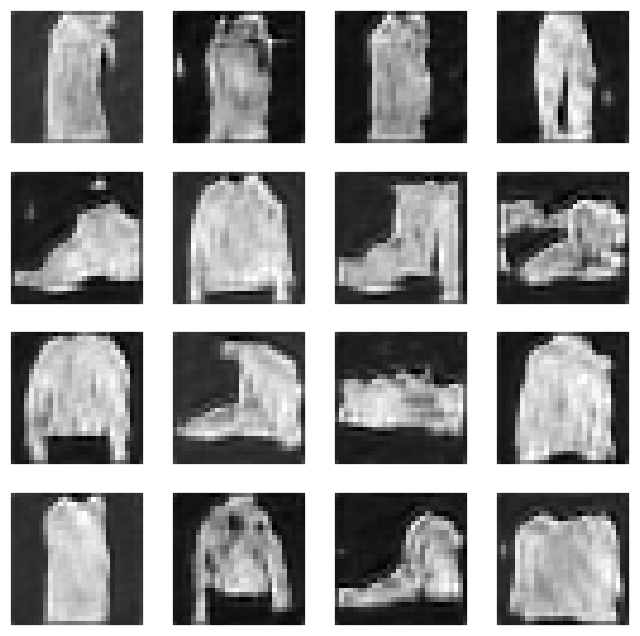

In [63]:
best_model.eval()
generated = generate_new_images(
        best_model,
        n_samples=16,
        n_steps=10
    )
show_images(generated, save_path=None)

In [45]:
# fake samples
n_samples=50000

os.makedirs(f"generated_ddgan_tv_FMNIST", exist_ok=True)

num_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for n in tqdm(num_steps, desc=f"Generating progress", colour="#00dd00"):
    
    torch.cuda.empty_cache()
    
    with torch.no_grad():

        generated = generate_new_images(
            best_model,
            n_samples=n_samples,
            n_steps=n
        )

    os.makedirs(f"generated_ddgan_tv_FMNIST/{n}", exist_ok=True)
    
    for i in range(len(generated)):
        save_image(torch.cat([generated[i],generated[i],generated[i]]), f"generated_ddgan_tv_FMNIST/{n}/img{i}.png")

Generating progress:   0%|          | 0/10 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

batches:   0%|          | 0/17 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
# extract features and calculate FID
from FID import extract_real_features, FID_score

# path_real = "datasets/FashionMNIST_png/"
# real_features = extract_real_features(path_real)

# with open('real_features.npy', "wb") as f:
#     np.save(f, real_features)
# torch.cuda.empty_cache()

with open("real_features.npy", 'rb') as f:
    real_features = np.load(f)

In [47]:
path_real = "real_features.npy"
num_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

scores = []

for n in tqdm(num_steps, leave=False, desc=f"Progress", colour="#009900"):
    torch.cuda.empty_cache()
    path_fake = f"generated_ddgan_tv_FMNIST/{n}/"
    scores.append(FID_score(path_real, path_fake, True))

with open('FID_scores_FMNIST_ddgan_tv.npy', "wb") as f:
    np.save(f, np.array(scores))

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

In [48]:
with open('FID_scores_FMNIST_ddgan_tv.npy', "rb") as f:
    scores = np.load(f)

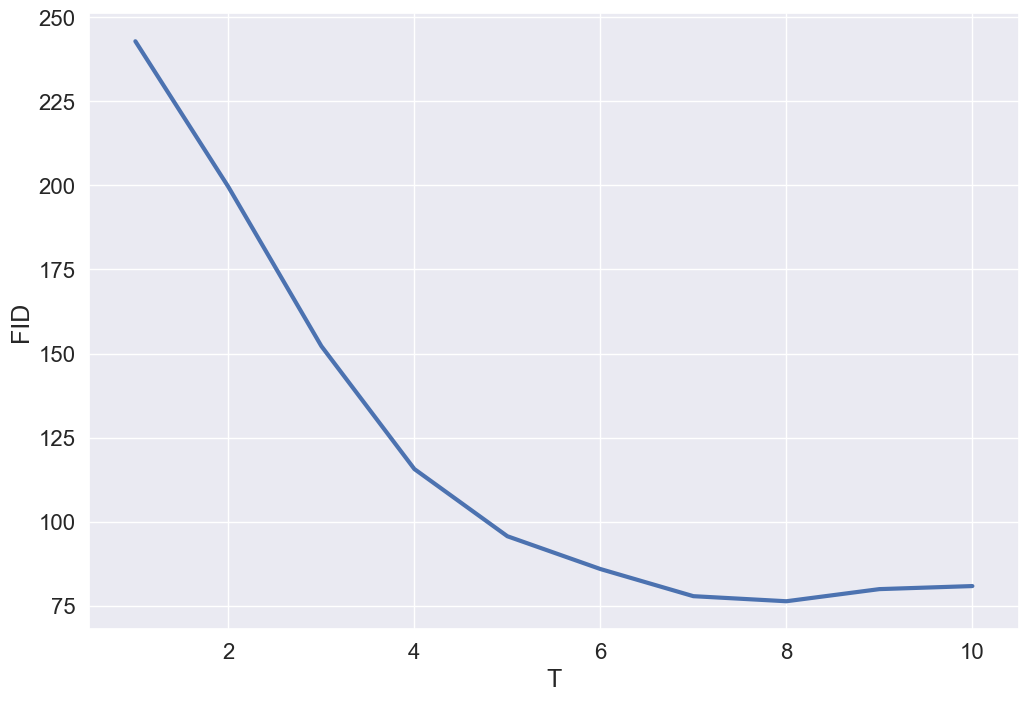

In [49]:
import seaborn as sns
sns.set_theme(style='darkgrid')

plt.figure(figsize=(12,8))

plt.plot(num_steps, scores, lw=3)

plt.xlabel("T", fontsize=18)
plt.ylabel("FID", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=0.5, right=10.5)

plt.savefig("DDGAN_TV_FID_FMNIST.png", bbox_inches='tight')
plt.show()